<a href="https://colab.research.google.com/github/the-pinbo/image-compression/blob/main/04_auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

In [2]:
# Download the dataset
mnist = tf.keras.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
print(f"X_train.shape => {X_train.shape}")
print(f"X_test.shape => {X_test.shape}")
print(f"Y_train.shape => {Y_train.shape}")
print(f"Y_test.shape => {Y_test.shape}")

11490434/11490434 [==============================] - 0s 0us/step
X_train.shape => (60000, 28, 28)
X_test.shape => (10000, 28, 28)
Y_train.shape => (60000,)
Y_test.shape => (10000,)


In [3]:
def build_autoencoder(input_shape, latent_dim, encoder_units, decoder_units, dropout_rate):
    # Encoder
    encoder_input = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Flatten()(encoder_input)
    for units in encoder_units:
        x = tf.keras.layers.Dense(units, activation='relu')(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    encoded_output = tf.keras.layers.Dense(latent_dim, activation='relu')(x)
    encoder = tf.keras.Model(inputs=encoder_input, outputs=encoded_output, name='encoder')

    # Decoder
    decoder_input = tf.keras.Input(shape=(latent_dim,))
    x = decoder_input
    for units in decoder_units:
        x = tf.keras.layers.Dense(units, activation='relu')(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(tf.math.reduce_prod(input_shape), activation='relu')(x)
    decoded_output = tf.keras.layers.Reshape(input_shape)(x)
    decoder = tf.keras.Model(inputs=decoder_input, outputs=decoded_output, name='decoder')

    # Autoencoder
    autoencoder_input = tf.keras.Input(shape=input_shape)
    encoded = encoder(autoencoder_input)
    decoded = decoder(encoded)
    autoencoder = tf.keras.Model(inputs=autoencoder_input, outputs=decoded, name='autoencoder')

    return autoencoder, encoder, decoder


In [4]:
def calculate_psnr(original, reconstructed):
    return compare_psnr(original, reconstructed, data_range=original.max() - original.min())

def calculate_ssim(original, reconstructed):
    return compare_ssim(original, reconstructed, multichannel=True)


In [5]:
def train_model_with_early_stopping(model, X_train, epochs, batch_size, patience=5):
    """
    Trains the given model on the provided data with early stopping.

    Parameters:
    model: A TensorFlow/Keras model.
    X_train (np.array): Training data.
    epochs (int): Number of epochs to train the model.
    batch_size (int): Batch size for training.
    patience (int): Number of epochs to wait for improvement before stopping.

    Returns:
    history: Training history object.
    """
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=patience, restore_best_weights=True)

    history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,
                        validation_split=0.2, callbacks=[early_stopping])
    return history

In [6]:
def predict_model(model, X_test):
    predictions = model.predict(X_test)
    return predictions


def plot_training_history(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
# Define model parameters
input_shape = X_train.shape[1:]
dropout_rate = 0.2
output_shape = X_train.shape[1:]
encoder_units = [512, 256, 128]
decoder_units = [128, 256, 512]

In [8]:
latent_dims = [2, 8, 32, 64]
autoencoders = dict()
encoders = dict()

for latent_dim in latent_dims:
    # Build and compile the autoencoder
    autoencoder, encoder, _ = build_autoencoder(input_shape, latent_dim, encoder_units, decoder_units, dropout_rate)
    autoencoder.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    autoencoders[latent_dim] = autoencoder
    encoders[latent_dim] = encoder
    print(f"Latent dim => {latent_dim}")
    print(autoencoder.summary(expand_nested=True))


Latent dim => 2
Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 encoder (Functional)        (None, 2)                 566402    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_1 (InputLayer)       [(None, 28, 28)]          0        |
|                                                               |
| flatten (Flatten)          (None, 784)               0        |
|                                                               |
| dense (Dense)              (None, 512)               401920   |
|                                                               |
| dropout (Dropout)          (None, 512)               0        |
|                                                               |
| dense_1 (Dense)            (None, 256

In [9]:
def visualize_reconstructions(original, reconstructed, n_images, title):
    plt.figure(figsize=(20, 4))
    for i in range(n_images):
        # Display original image
        ax = plt.subplot(2, n_images, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed image
        ax = plt.subplot(2, n_images, i + 1 + n_images)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.suptitle(title)
    plt.show()

def train_model(model, X_train, epochs, batch_size, patience=5):
    """
    Trains the given model on the provided data with early stopping.

    Parameters:
    model: A TensorFlow/Keras model.
    X_train (np.array): Training data.
    epochs (int): Number of epochs to train the model.
    batch_size (int): Batch size for training.
    patience (int): Number of epochs to wait for improvement before stopping.

    Returns:
    history: Training history object.
    """
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=patience, restore_best_weights=True)

    history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,
                        validation_split=0.2, callbacks=[early_stopping])
    return history

Latent dim => 2
Epoch 1/50
94/94 [==============================] - 5s 57ms/step - loss: 0.1248 - val_loss: 0.1241
Epoch 2/50
94/94 [==============================] - 6s 60ms/step - loss: 0.1249 - val_loss: 0.1241
Epoch 3/50
94/94 [==============================] - 6s 64ms/step - loss: 0.1249 - val_loss: 0.1241
Epoch 4/50
94/94 [==============================] - 6s 60ms/step - loss: 0.1248 - val_loss: 0.1241
Epoch 5/50
94/94 [==============================] - 5s 56ms/step - loss: 0.1248 - val_loss: 0.1241
Epoch 6/50
94/94 [==============================] - 6s 61ms/step - loss: 0.1248 - val_loss: 0.1241
Epoch 7/50
94/94 [==============================] - 5s 56ms/step - loss: 0.1248 - val_loss: 0.1241
Epoch 8/50
313/313 [==============================] - 1s 3ms/step


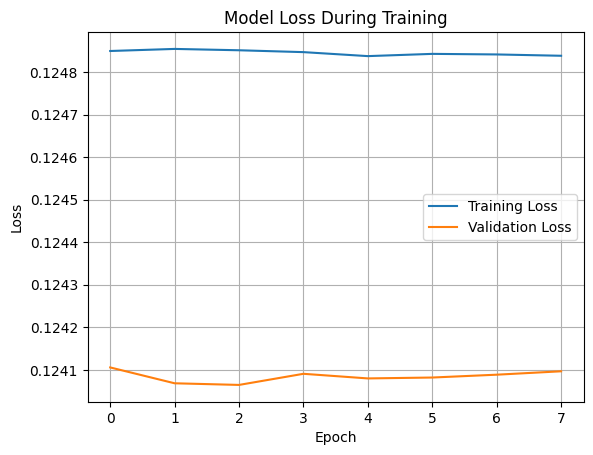

<ipython-input-4-2edf5d512d37>:5: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return compare_ssim(original, reconstructed, multichannel=True)


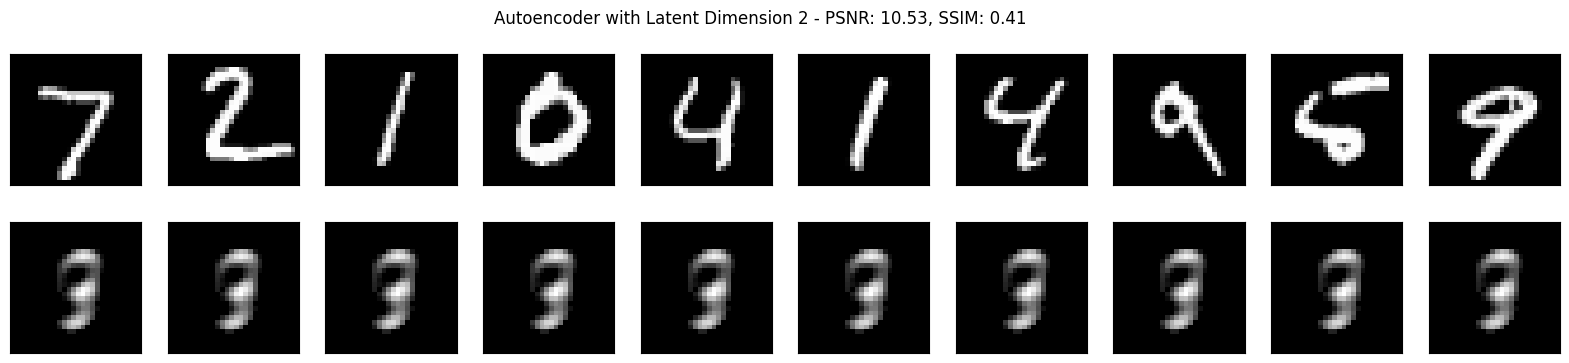

Latent dim => 8
Epoch 1/50
94/94 [==============================] - 7s 62ms/step - loss: 0.1261 - val_loss: 0.1189
Epoch 2/50
94/94 [==============================] - 5s 56ms/step - loss: 0.1114 - val_loss: 0.1042
Epoch 3/50
94/94 [==============================] - 5s 58ms/step - loss: 0.1017 - val_loss: 0.0930
Epoch 4/50
94/94 [==============================] - 5s 57ms/step - loss: 0.0907 - val_loss: 0.0821
Epoch 5/50
94/94 [==============================] - 5s 56ms/step - loss: 0.0831 - val_loss: 0.0750
Epoch 6/50
94/94 [==============================] - 6s 61ms/step - loss: 0.0788 - val_loss: 0.0713
Epoch 7/50
94/94 [==============================] - 10s 105ms/step - loss: 0.0759 - val_loss: 0.0681
Epoch 8/50
94/94 [==============================] - 5s 56ms/step - loss: 0.0735 - val_loss: 0.0657
Epoch 9/50
94/94 [==============================] - 6s 65ms/step - loss: 0.0718 - val_loss: 0.0636
Epoch 10/50
94/94 [==============================] - 5s 56ms/step - loss: 0.0705 - val_loss

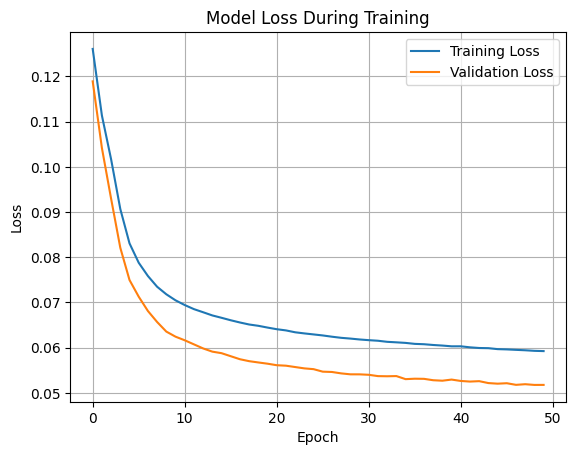

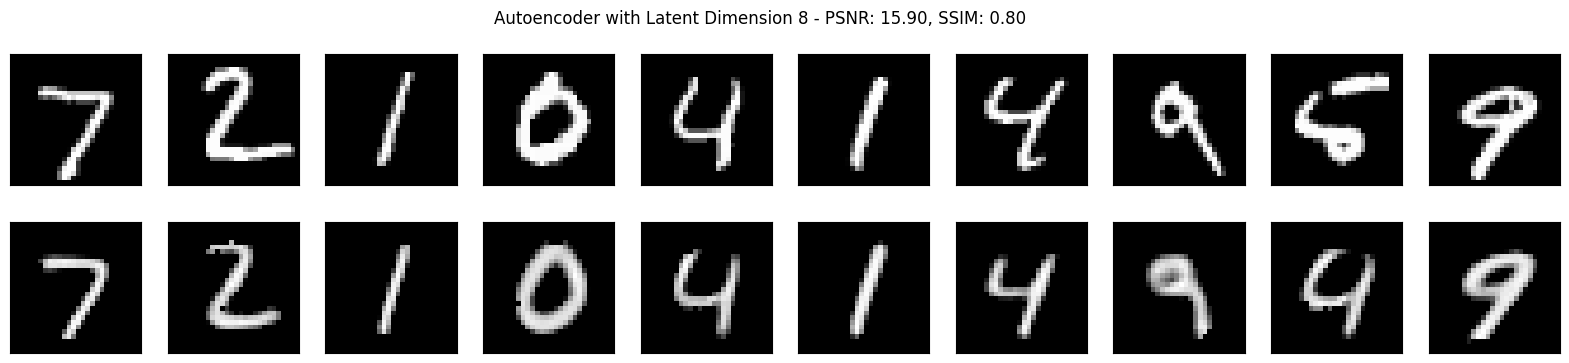

Latent dim => 32
Epoch 1/50
94/94 [==============================] - 7s 60ms/step - loss: 0.1193 - val_loss: 0.1054
Epoch 2/50
94/94 [==============================] - 6s 62ms/step - loss: 0.1005 - val_loss: 0.0888
Epoch 3/50
94/94 [==============================] - 5s 58ms/step - loss: 0.0884 - val_loss: 0.0790
Epoch 4/50
94/94 [==============================] - 6s 62ms/step - loss: 0.0811 - val_loss: 0.0708
Epoch 5/50
94/94 [==============================] - 5s 58ms/step - loss: 0.0763 - val_loss: 0.0675
Epoch 6/50
94/94 [==============================] - 6s 62ms/step - loss: 0.0730 - val_loss: 0.0649
Epoch 7/50
94/94 [==============================] - 5s 58ms/step - loss: 0.0705 - val_loss: 0.0617
Epoch 8/50
94/94 [==============================] - 6s 62ms/step - loss: 0.0686 - val_loss: 0.0596
Epoch 9/50
94/94 [==============================] - 5s 58ms/step - loss: 0.0673 - val_loss: 0.0583
Epoch 10/50
94/94 [==============================] - 6s 62ms/step - loss: 0.0659 - val_loss:

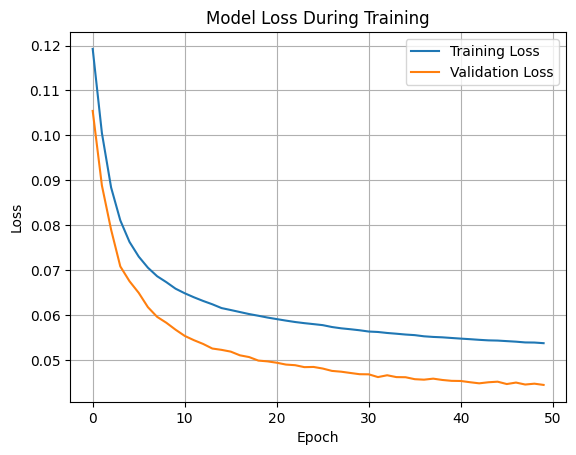

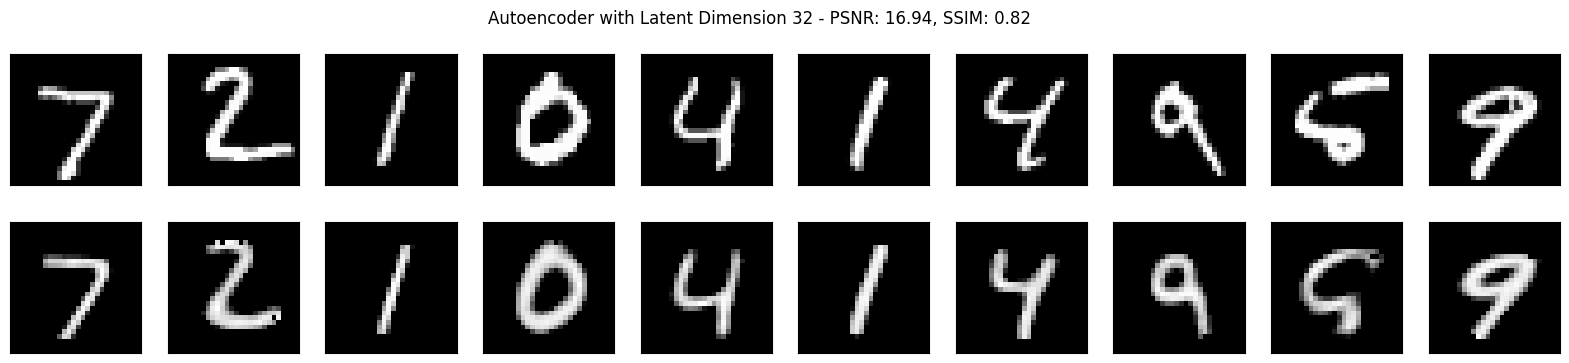

Latent dim => 64
Epoch 1/50
94/94 [==============================] - 7s 64ms/step - loss: 0.1190 - val_loss: 0.1051
Epoch 2/50
94/94 [==============================] - 6s 65ms/step - loss: 0.0990 - val_loss: 0.0871
Epoch 3/50
94/94 [==============================] - 6s 64ms/step - loss: 0.0856 - val_loss: 0.0757
Epoch 4/50
94/94 [==============================] - 6s 59ms/step - loss: 0.0787 - val_loss: 0.0700
Epoch 5/50
94/94 [==============================] - 6s 63ms/step - loss: 0.0745 - val_loss: 0.0660
Epoch 6/50
94/94 [==============================] - 6s 59ms/step - loss: 0.0716 - val_loss: 0.0624
Epoch 7/50
94/94 [==============================] - 6s 63ms/step - loss: 0.0695 - val_loss: 0.0600
Epoch 8/50
94/94 [==============================] - 6s 59ms/step - loss: 0.0677 - val_loss: 0.0579
Epoch 9/50
94/94 [==============================] - 6s 63ms/step - loss: 0.0663 - val_loss: 0.0568
Epoch 10/50
94/94 [==============================] - 6s 59ms/step - loss: 0.0651 - val_loss:

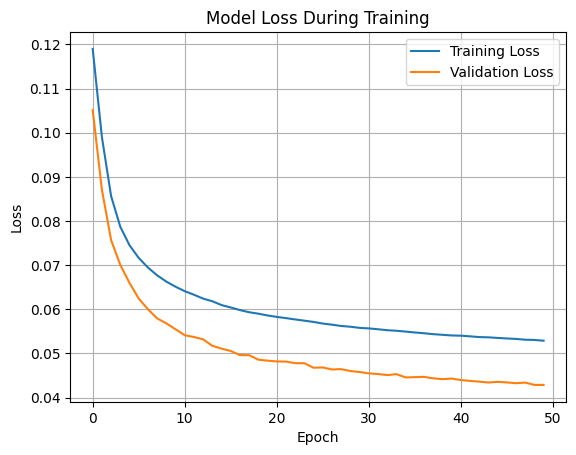

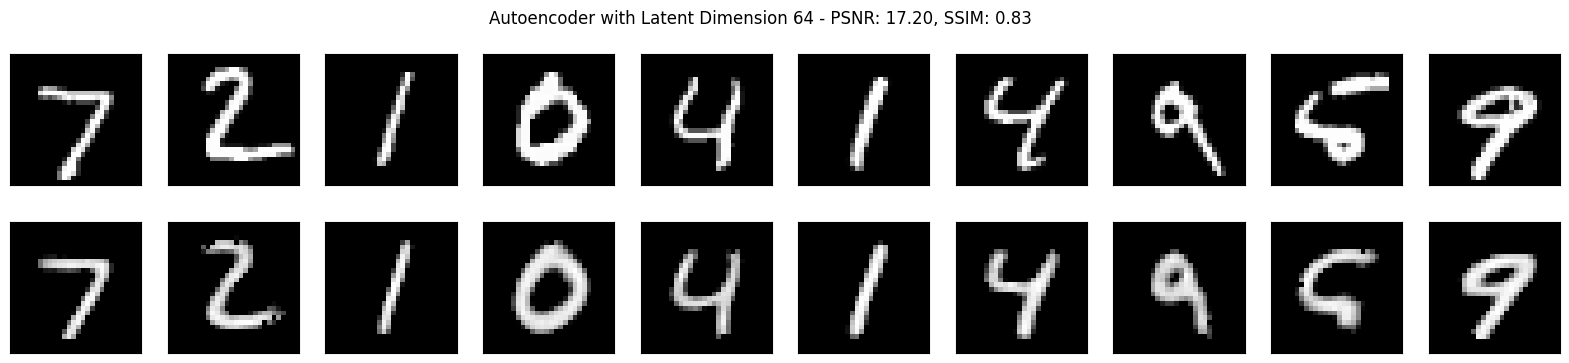

In [11]:
reconstructed_images = dict()
psnr_values = []
ssim_values = []
n_images_to_display = 10

for latent_dim, autoencoder in autoencoders.items():
    print(f"Latent dim => {latent_dim}")
    # Train the model
    history = train_model(autoencoder, X_train, epochs=50, batch_size=512)
    # Predict using the model
    predictions = predict_model(autoencoder, X_test)
    reconstructed_images[latent_dim] = predictions
    # Plot the training history
    plot_training_history(history)

    # Calculate PSNR and SSIM
    psnr = calculate_psnr(X_test, predictions)
    ssim = calculate_ssim(X_test, predictions)
    psnr_values.append(psnr)
    ssim_values.append(ssim)

    # Visualization
    title = f"Autoencoder with Latent Dimension {latent_dim} - PSNR: {psnr:.2f}, SSIM: {ssim:.2f}"
    visualize_reconstructions(X_test, predictions, n_images_to_display, title)


In [18]:
def plot_image_comparision(index_of_image_to_compare):
    selected_image = X_test[index_of_image_to_compare]
    plt.figure(figsize=(20, 10))
    for i, latent_dim in enumerate(latent_dims):
        reconstructed_image = reconstructed_images[latent_dim][index_of_image_to_compare]

        # Display reconstructed image
        ax = plt.subplot(2, len(latent_dims), i + 1)
        plt.imshow(reconstructed_image.reshape(28, 28), cmap='gray')
        plt.title(f"Latent Dim: {latent_dim}\nPSNR: {psnr_values[i]:.2f}\nSSIM: {ssim_values[i]:.2f}")
        plt.axis('off')

    # Display the original image for comparison
    ax = plt.subplot(2, len(latent_dims), len(latent_dims) + 1)
    plt.imshow(selected_image.reshape(28, 28), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


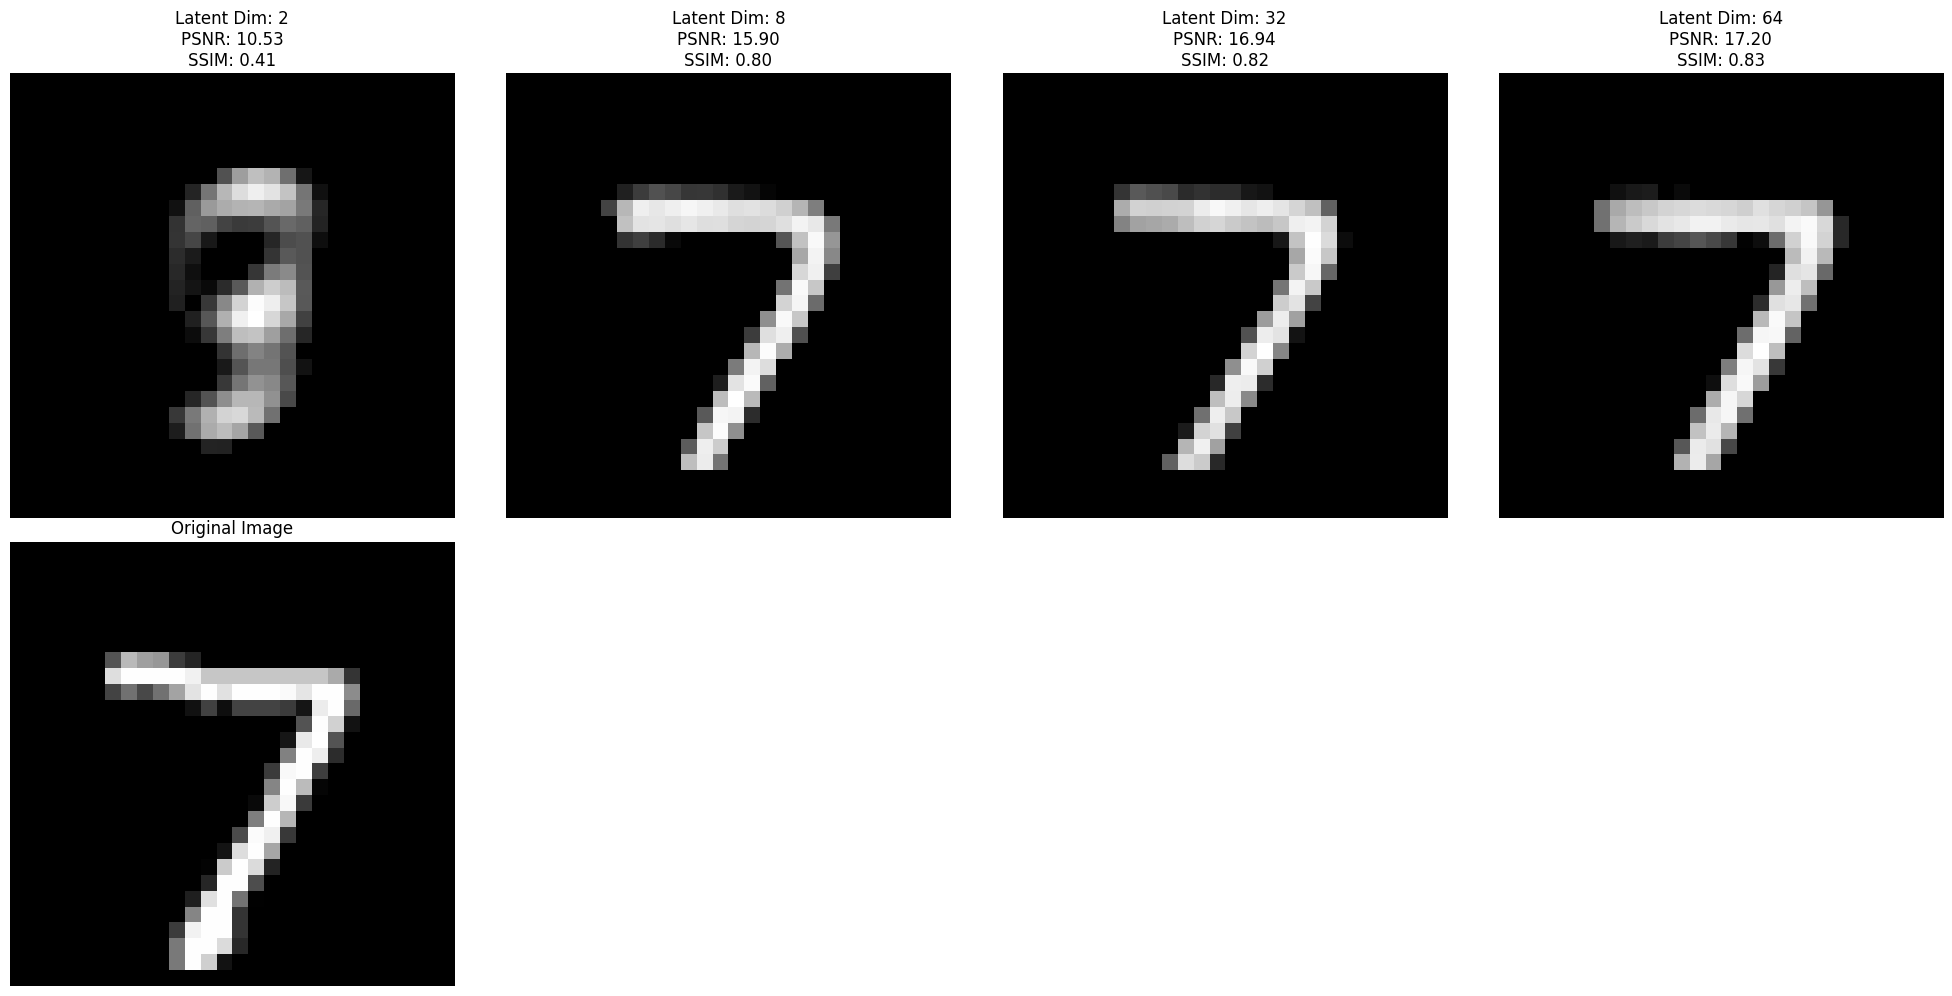

In [19]:
# Select an image for comparison
plot_image_comparision(0)

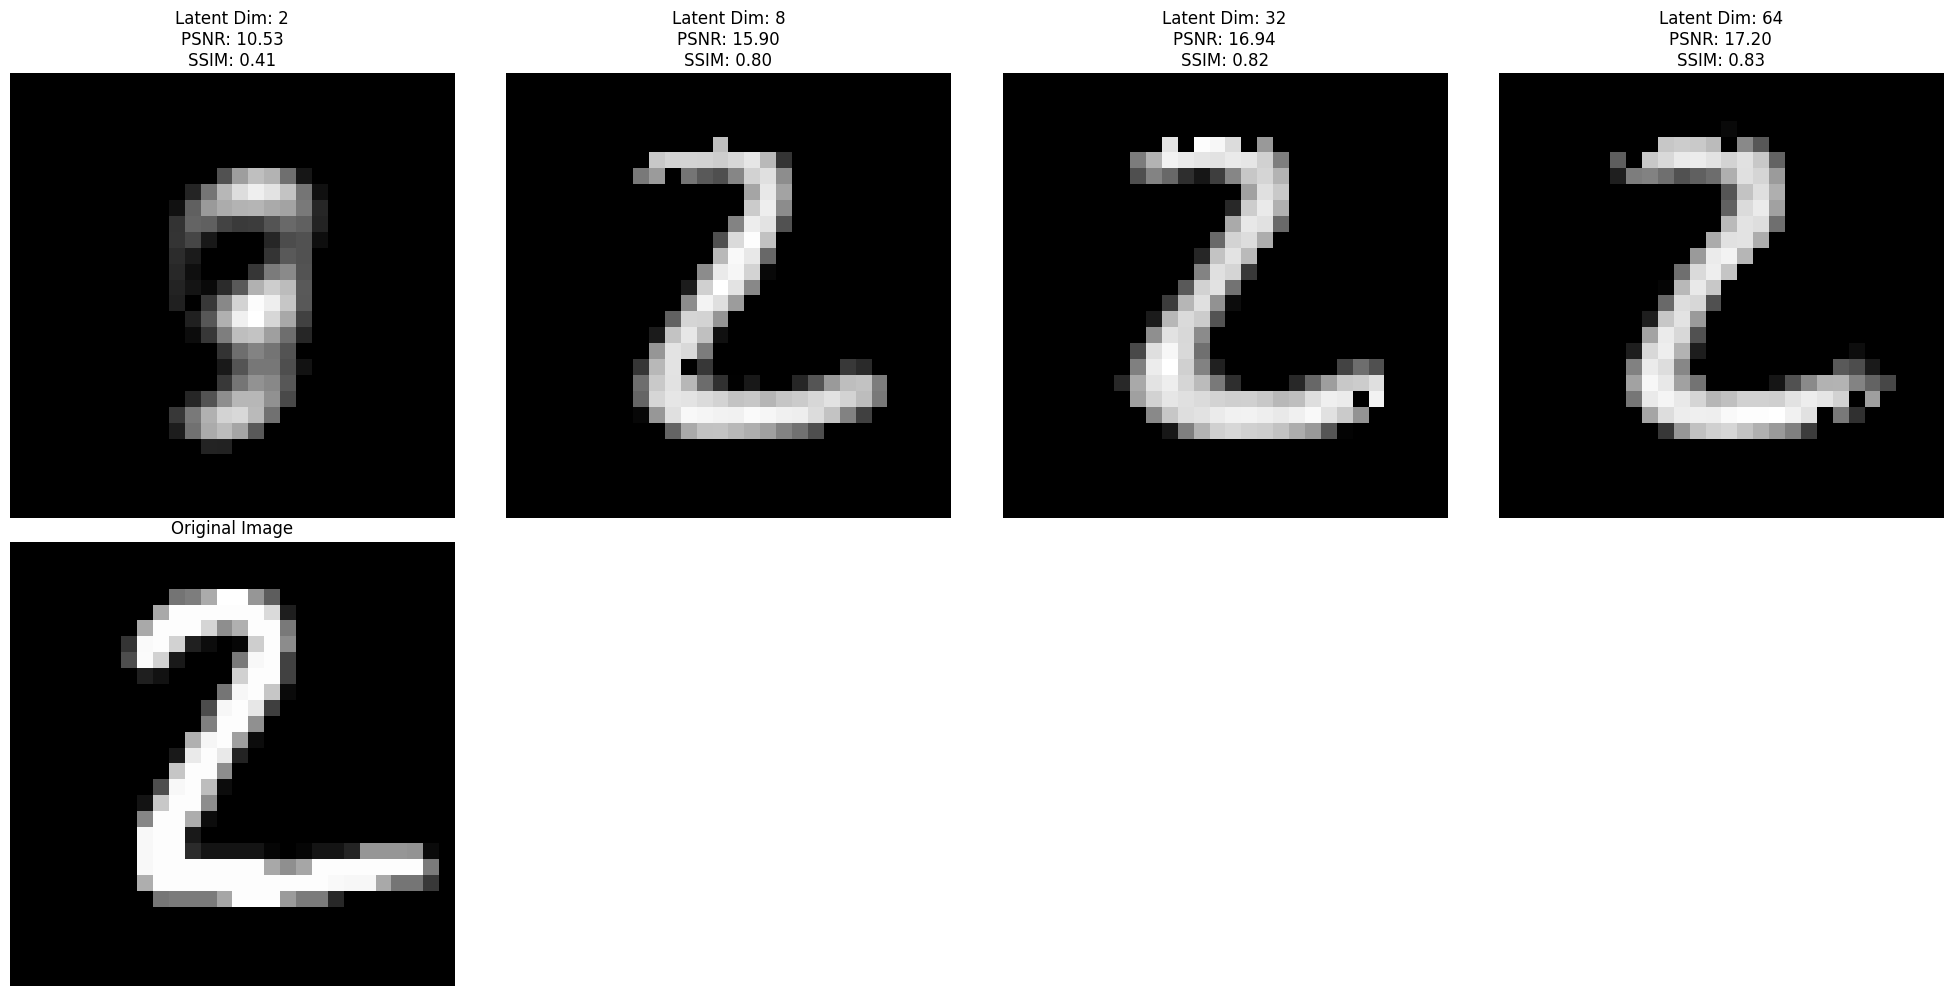

In [20]:
# Select an image for comparison
plot_image_comparision(1)

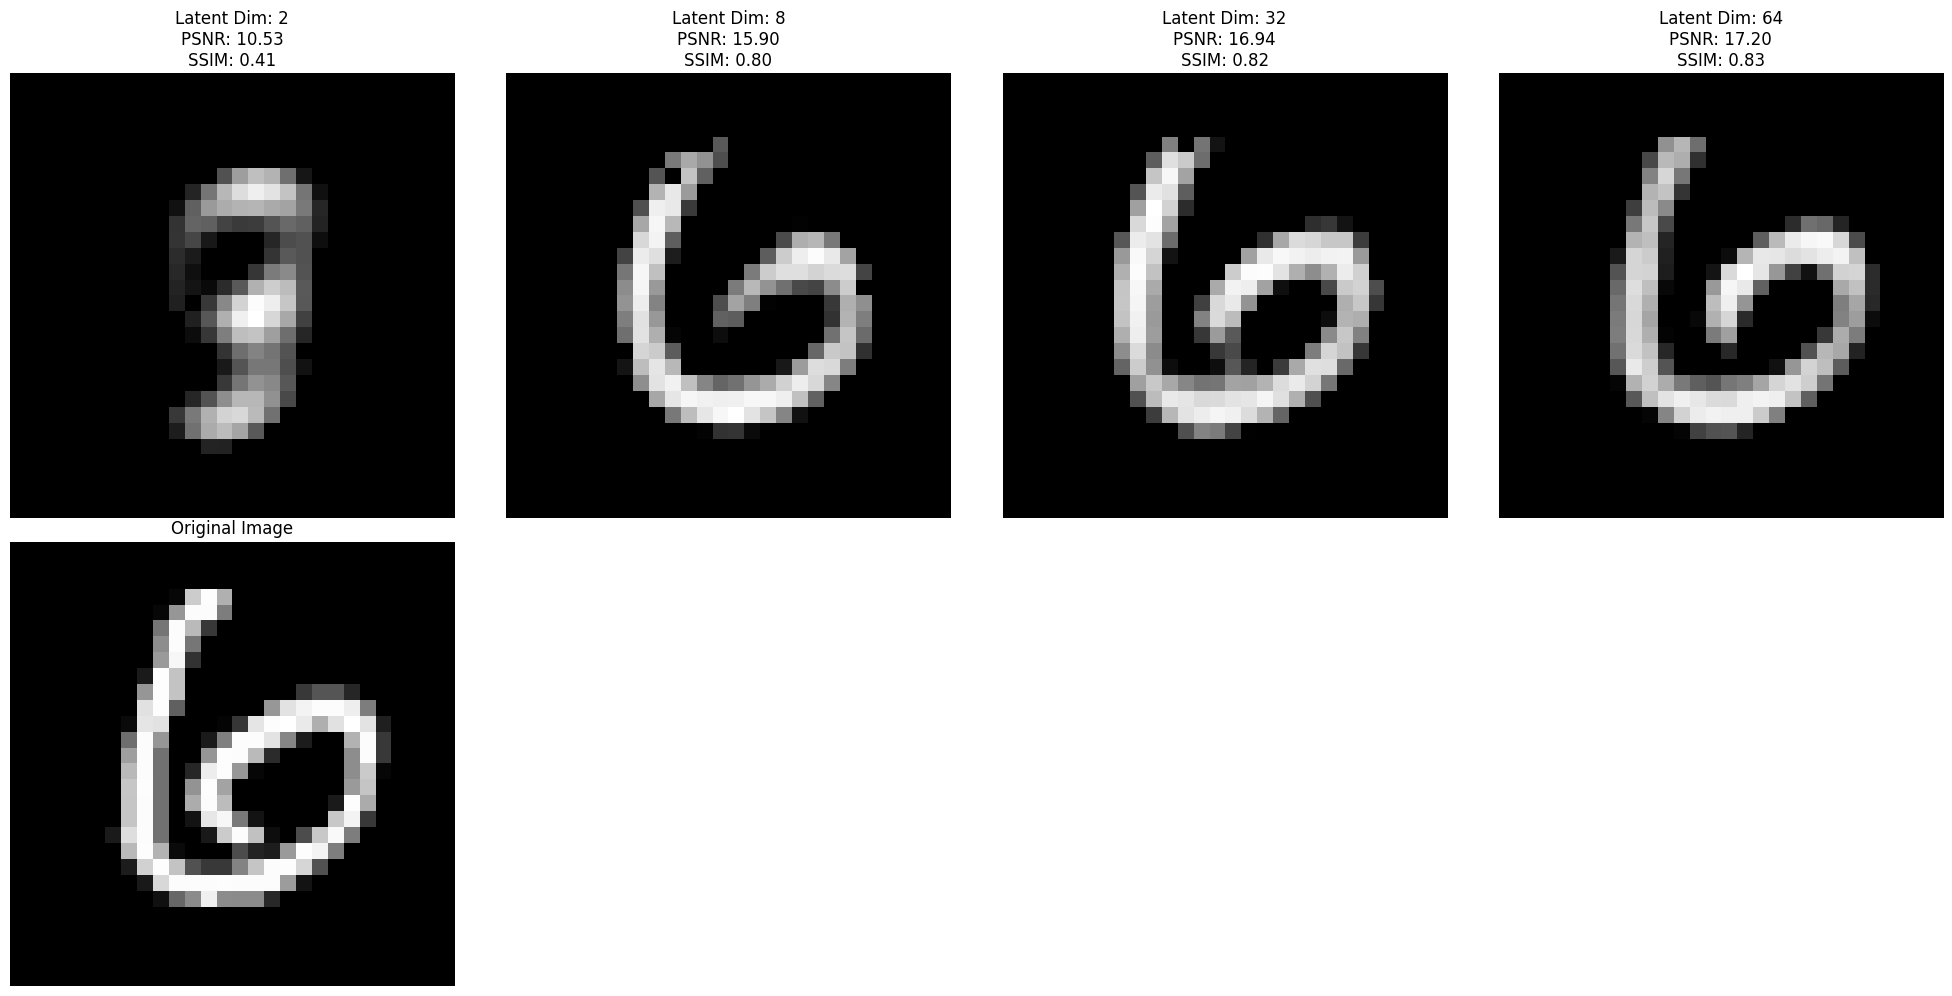

In [21]:
# Select an image for comparison
plot_image_comparision(11)

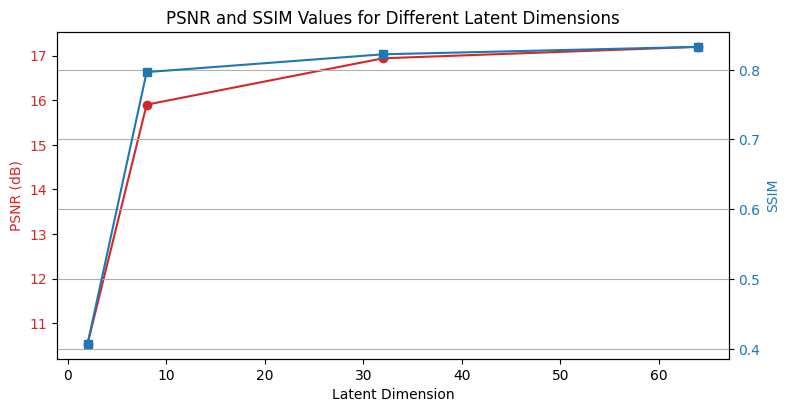

In [13]:
# Plot the PSNR and SSIM graphs
fig, ax1 = plt.subplots(figsize=(8, 4))

# PSNR Plot
color = 'tab:red'
ax1.set_xlabel('Latent Dimension')
ax1.set_ylabel('PSNR (dB)', color=color)
ax1.plot(latent_dims, psnr_values, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# SSIM Plot on the same x-axis
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('SSIM', color=color)
ax2.plot(latent_dims, ssim_values, 's-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Layout and grid
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.grid(True)
plt.title('PSNR and SSIM Values for Different Latent Dimensions')

plt.show()

In [ ]:
# def visualize_latent_space(encoder, X_test, y_test, num_classes=10):
#     # Pass the test dataset through the encoder to obtain the latent representations
#     latent_representations = encoder.predict(X_test)

#     # Assuming the latent space is 2-dimensional
#     z1 = latent_representations[:, 0]
#     z2 = latent_representations[:, 1]

#     plt.figure(figsize=(12, 10))
#     cmap = plt.cm.get_cmap('hsv', num_classes)

#     # Create a scatter plot, with color coding for each class
#     for i in range(num_classes):
#         indices = np.where(y_test == i)
#         plt.scatter(z1[indices], z2[indices], label=i, s=2, cmap=cmap(i))

#     # Add a color bar, set a title and labels, and display the plot
#     cbar = plt.colorbar(ticks=range(num_classes))
#     cbar.set_label('Digit Class')
#     plt.xlabel('Encoder first dimension')
#     plt.ylabel('Encoder second dimension')
#     plt.title('Latent Space Visualization of MNIST Data')
#     plt.legend()
#     plt.grid(True)
#     plt.show()


# visualize_latent_space(encoder, X_test, y_test)
